In [1]:
import sys
from os import getcwd
from os.path import dirname, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate

SRC_DIR = join(dirname(getcwd()), 'MAMMAL')
sys.path.append(SRC_DIR)
BASE_DIR = dirname(SRC_DIR)
DATA_DIR = join(BASE_DIR, 'data')
TEST_DIR = join(DATA_DIR, 'test')
EXAM_DIR = join(DATA_DIR, 'diurnal_test_data')

import Diurnal
from Parse import parseIM as pi
from Utils import ProcessingUtils as pu


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)

# Load INTERMAGNET Data

Loaded bou20190911psec.sec
Loaded bou20190912psec.sec
Loaded frd20190911psec.sec
Loaded frd20190912psec.sec
Loaded frn20190911psec.sec
Loaded frn20190912psec.sec


100%|██████████| 692/692 [00:01<00:00, 545.75it/s]


RMSE: 267.3244711396219
RMSE: 10.869259973212195


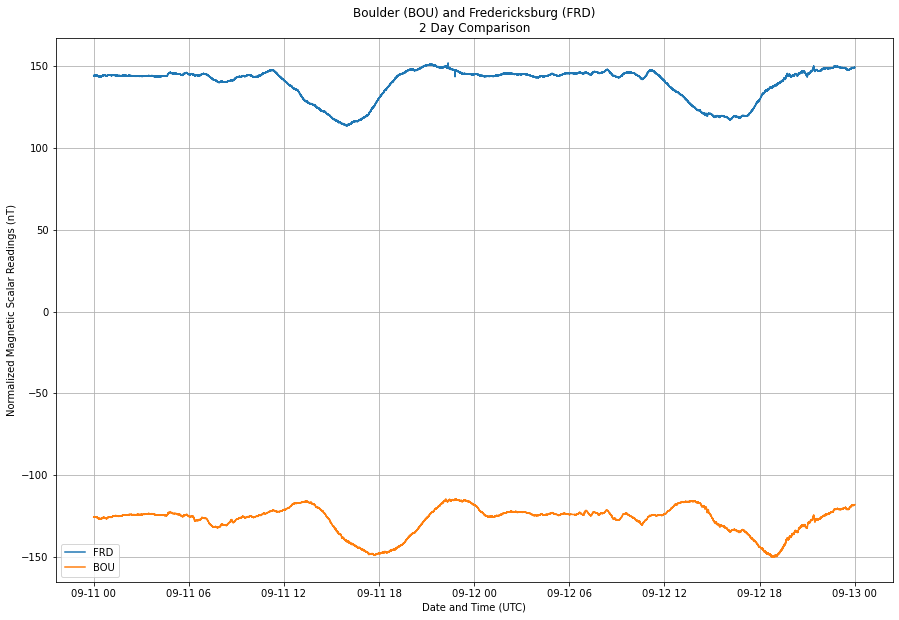

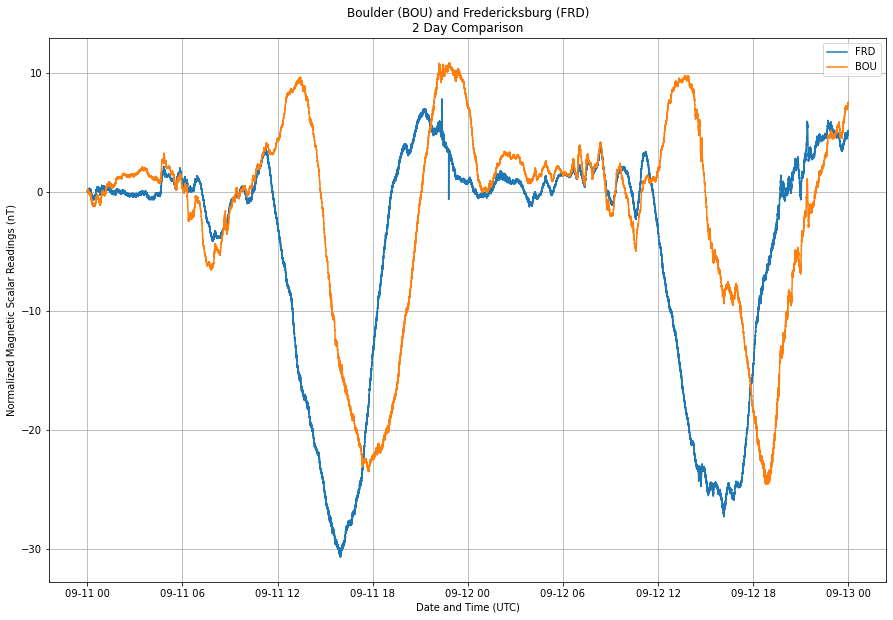

In [3]:
df_dict = pi.loadInterMagData(TEST_DIR)
    
from_name = 'BOU'
to_name   = 'FRD'

from_df = df_dict[from_name]
to_df   = df_dict[to_name]

to_df = pu.reject_outliers(to_df,
                           window_size=250,
                           std_lim=3)

to_IGRF_f   = np.array(to_df.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df.F)
from_f = np.array(from_df.F)
    
to_f_no_core   = np.array(to_df.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df.epoch_sec)
from_t = np.array(from_df.epoch_sec)

plt.figure()
plt.title('Boulder (BOU) and Fredericksburg (FRD)\n2 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()
    
plt.figure()
plt.title('Boulder (BOU) and Fredericksburg (FRD)\n2 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core - to_f_no_core[0], label=to_name)
plt.plot(from_df.datetime, from_f_no_core - from_f_no_core[0], label=from_name)
plt.legend()
plt.grid()

print('RMSE:', pu.rmse(to_f_no_core, from_f_no_core[:len(to_f)])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers
print('RMSE:', pu.rmse(to_f_no_core - to_f_no_core[0], from_f_no_core[:len(to_f)] - from_f_no_core[0])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers

# Simple Longitude Normalization

RMSE: 266.84286256867483


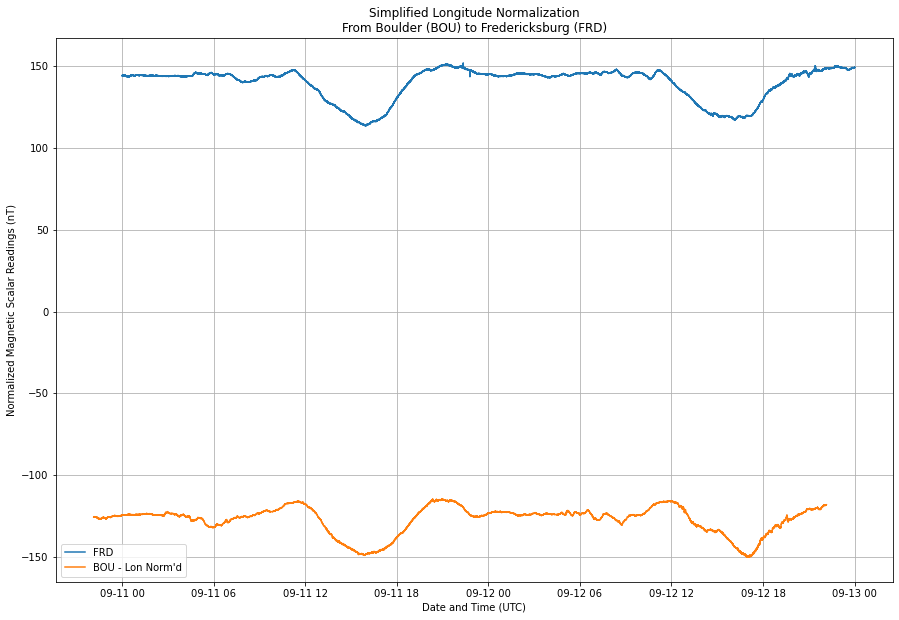

In [4]:
lon_diff     = from_df.LONG.mean() - to_df.LONG.mean()
lon_t_offset = pd.Timedelta(seconds=lon_diff / Diurnal.E_ROT_DEG_S)
bou_shift_t  = from_df.epoch_sec + lon_t_offset.total_seconds()

plt.figure()
plt.title('Simplified Longitude Normalization\nFrom Boulder (BOU) to Fredericksburg (FRD)')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime + lon_t_offset, from_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

interp_lpf = interpolate.interp1d(bou_shift_t, from_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= bou_shift_t.min(), to_t <= bou_shift_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

bou_shift_interp = interp_lpf(interp_t)

print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       bou_shift_interp))

# Frequency-Based Longitude Normalization

RMSE: 266.87837777008167


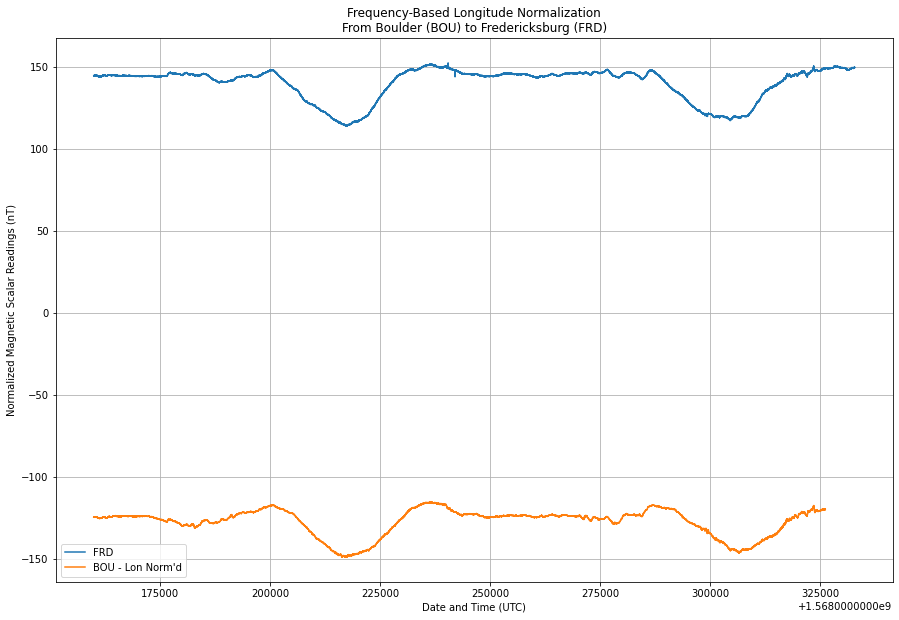

In [6]:
from_combined_t, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean())
from_combined_f_no_core = from_combined_f - from_IGRF_f

plt.figure()
plt.title('Frequency-Based Longitude Normalization\nFrom Boulder (BOU) to Fredericksburg (FRD)')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec, to_f_no_core, label=to_name)
plt.plot(from_combined_t, from_combined_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       from_combined_f_no_core[:len(to_f_no_core[interp_mask])]))

# Find Optimal Scale and Offset Parameters

Optimal scale: 1.085134182785885
Optimal offset: 277.6792162949522
RMSE: 4.630734469499371


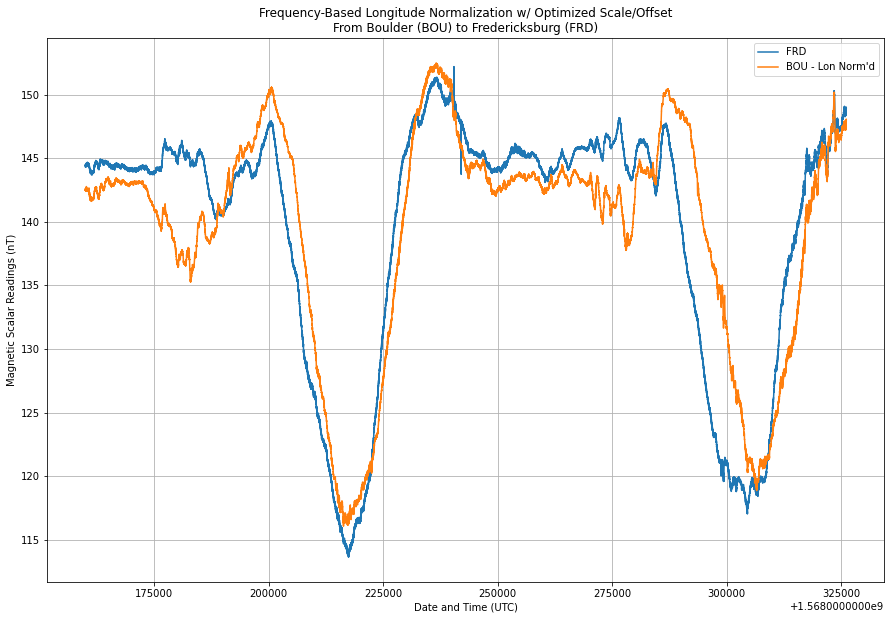

In [7]:
interp_combined = interpolate.interp1d(from_combined_t, from_combined_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= from_combined_t.min(), to_t <= from_combined_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

from_combined_interp = interp_combined(interp_t)

offset, scale       = Diurnal.calibrate([0, 1], from_combined_interp, to_f_no_core[interp_mask])
from_combined_opt_f = Diurnal.apply_cal([offset, scale], from_combined_f_no_core)

print('Optimal scale:',  scale)
print('Optimal offset:', offset)

plt.figure()
plt.title('Frequency-Based Longitude Normalization w/ Optimized Scale/Offset\nFrom Boulder (BOU) to Fredericksburg (FRD)')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label=to_name)
plt.plot(from_combined_t, from_combined_opt_f, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       from_combined_opt_f[:len(to_f_no_core[interp_mask])]))

# Test Optimal Parameters for Next Day's Data

Loaded bou20190913psec.sec
Loaded frd20190913psec.sec
Loaded frn20190913psec.sec


100%|██████████| 346/346 [00:00<00:00, 554.56it/s]


RMSE: 268.2980777028462
RMSE: 3.635806103790872


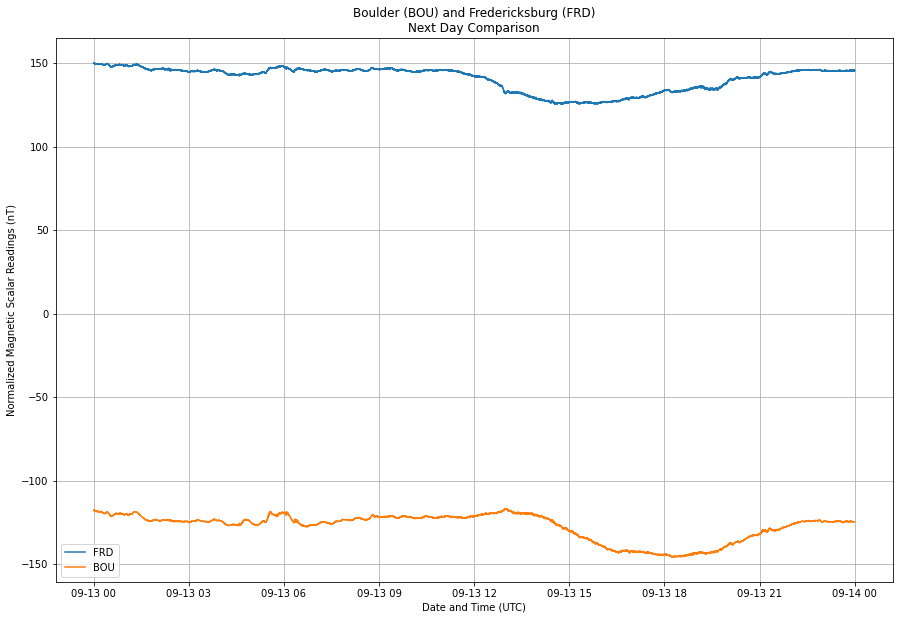

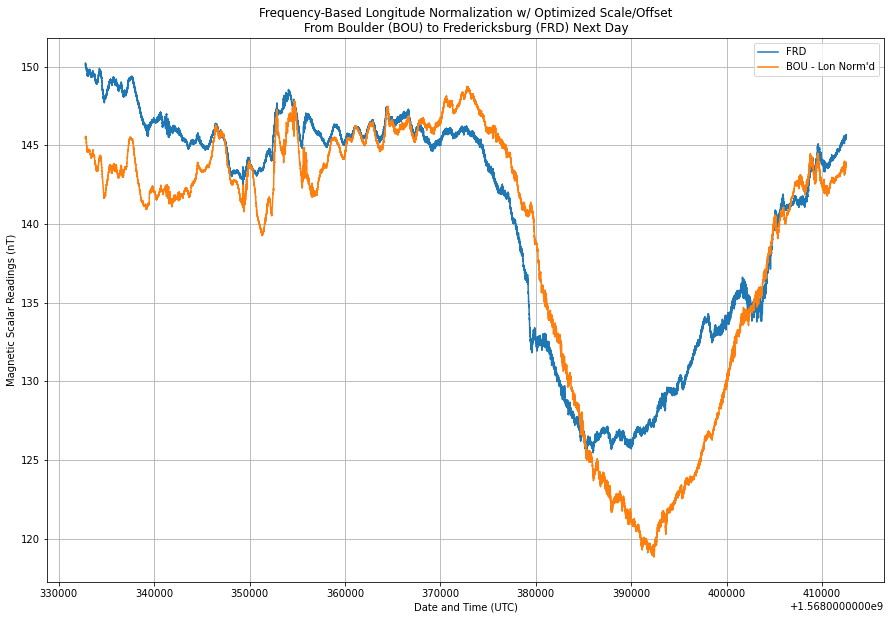

In [14]:
df_dict = pi.loadInterMagData(EXAM_DIR)
    
from_name = 'BOU'
to_name   = 'FRD'

from_df = df_dict[from_name]
to_df   = df_dict[to_name]

to_df = pu.reject_outliers(to_df,
                           window_size=250,
                           std_lim=3)

to_IGRF_f   = np.array(to_df.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df.F)
from_f = np.array(from_df.F)
    
to_f_no_core   = np.array(to_df.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df.epoch_sec)
from_t = np.array(from_df.epoch_sec)


plt.figure()
plt.title('Boulder (BOU) and Fredericksburg (FRD)\nNext Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()


from_combined_t, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean())
from_combined_f_no_core = from_combined_f - from_IGRF_f

interp_combined = interpolate.interp1d(from_combined_t, from_combined_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= from_combined_t.min(), to_t <= from_combined_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

from_combined_interp = interp_combined(interp_t)

from_combined_opt_f = Diurnal.apply_cal([offset, scale], from_combined_f_no_core)


plt.figure()
plt.title('Frequency-Based Longitude Normalization w/ Optimized Scale/Offset\nFrom Boulder (BOU) to Fredericksburg (FRD) Next Day')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label=to_name)
plt.plot(from_combined_t, from_combined_opt_f, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

print('RMSE:', pu.rmse(to_f_no_core, from_f_no_core[:len(to_f)])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers
print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       from_combined_opt_f[:len(to_f_no_core[interp_mask])]))